# Musical Key Detection

This notebook loads an audio file and computes key-related features of that file, including an estimate of the track's key.

While not 100% sure, I think this assumes equal temperament. 

## Load the module containing the class definition

In [1]:
from music_production_and_performance.features.KeyDetection import KeyDetection

## Bach

[{'hop_length': 1024,
  'key_as_chromatic_index': 4,
  'key_as_pitch_class': 'E',
  'method': 'Short-Time Fourier Transform',
  'track_title': 'Bach',
  'track_to_analyze_filename': '/home/emily/Downloads/02 - Minuet from The '
                               'Anna Magdalena Bach Notebook, Anh. 114.mp3'},
 {'hop_length': 1024,
  'key_as_chromatic_index': 4,
  'key_as_pitch_class': 'E',
  'method': 'Constant-Q Transform',
  'track_title': 'Bach',
  'track_to_analyze_filename': '/home/emily/Downloads/02 - Minuet from The '
                               'Anna Magdalena Bach Notebook, Anh. 114.mp3'}]


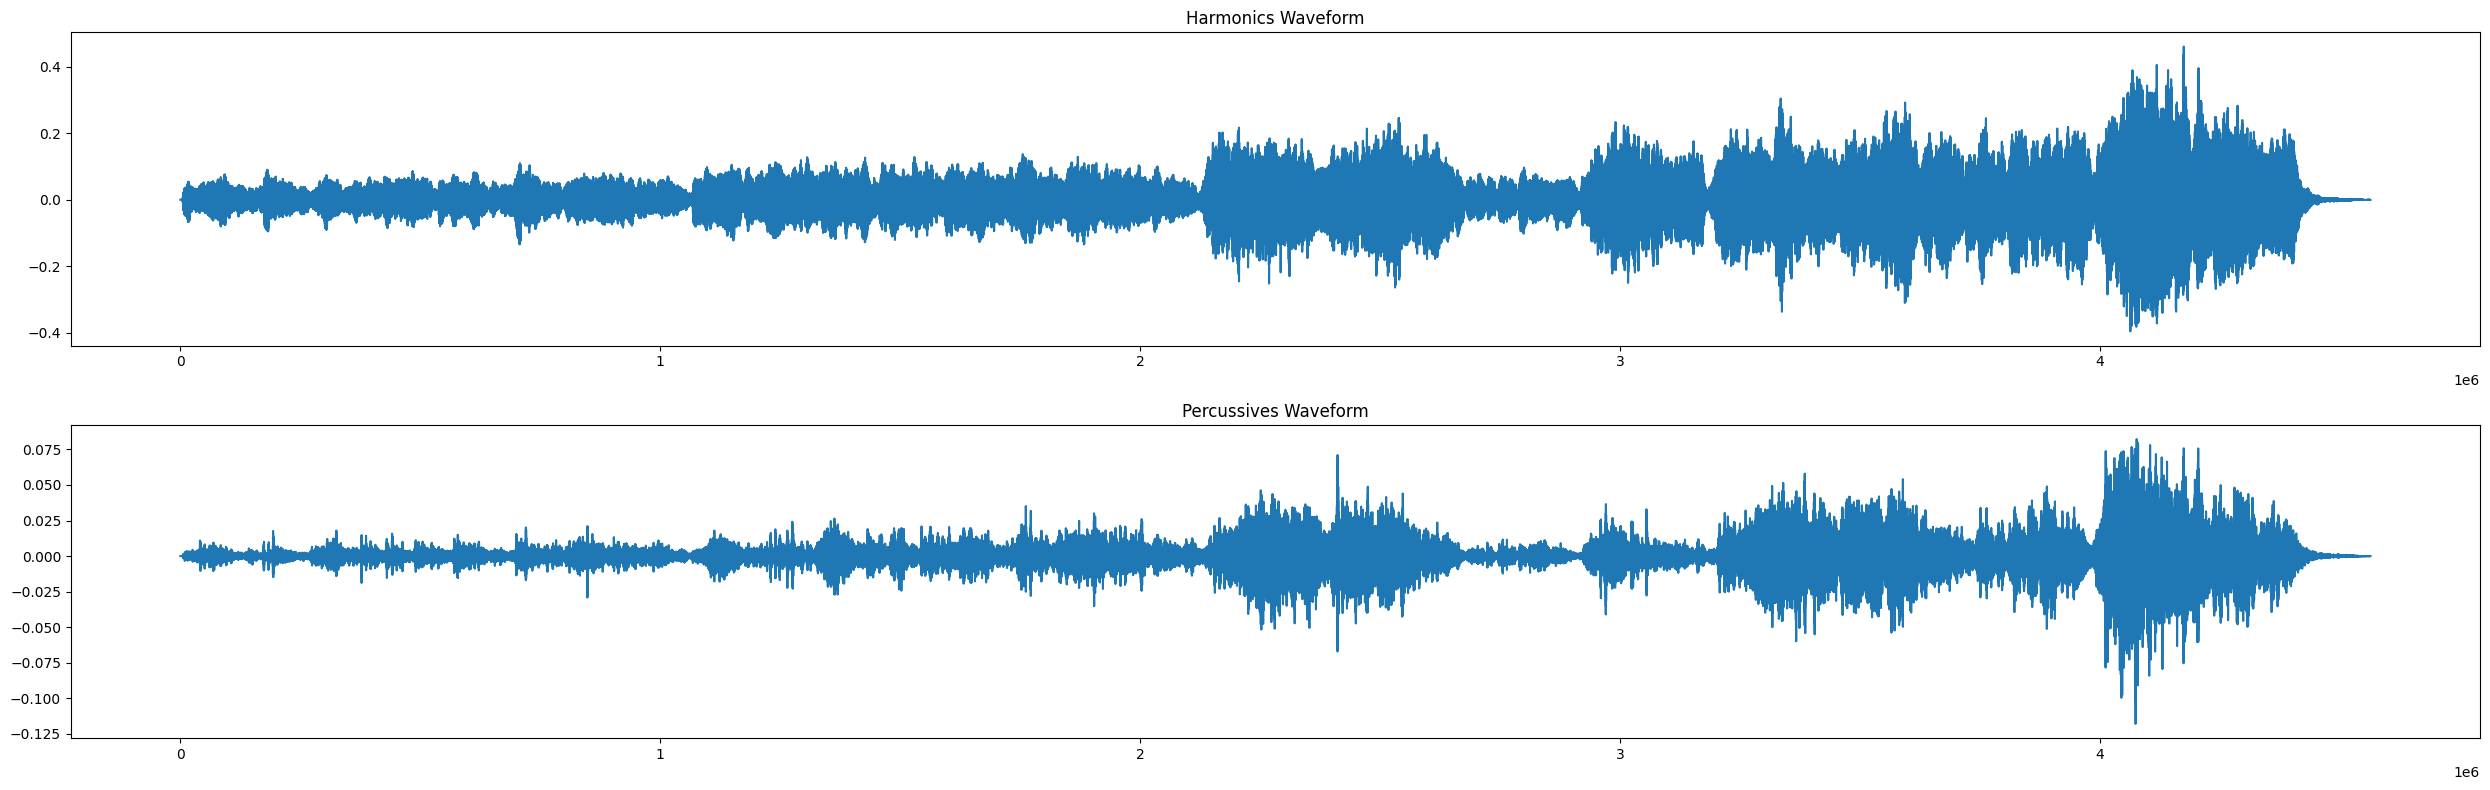

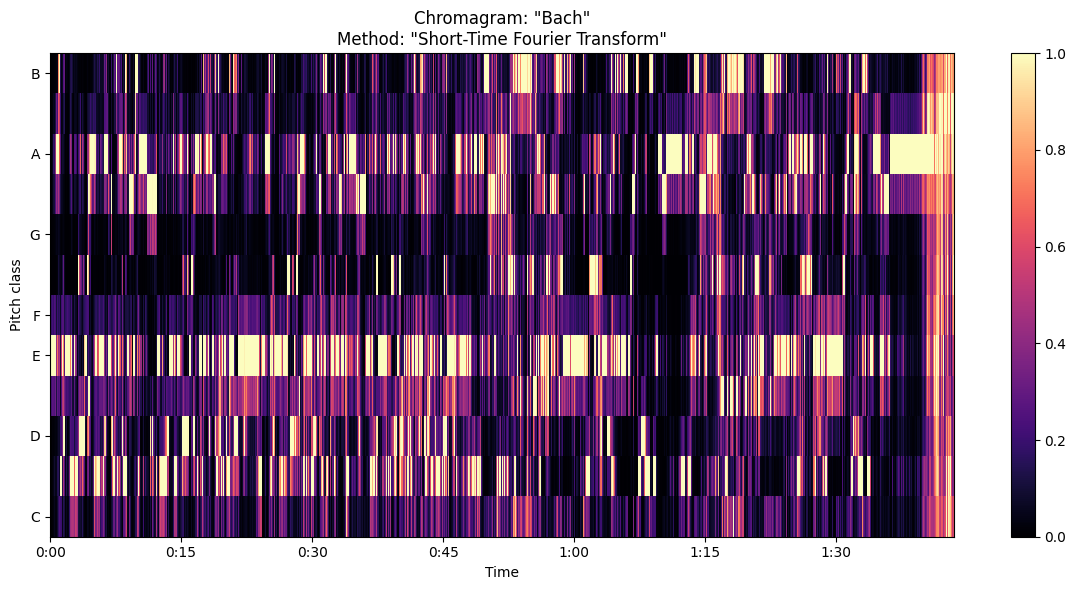

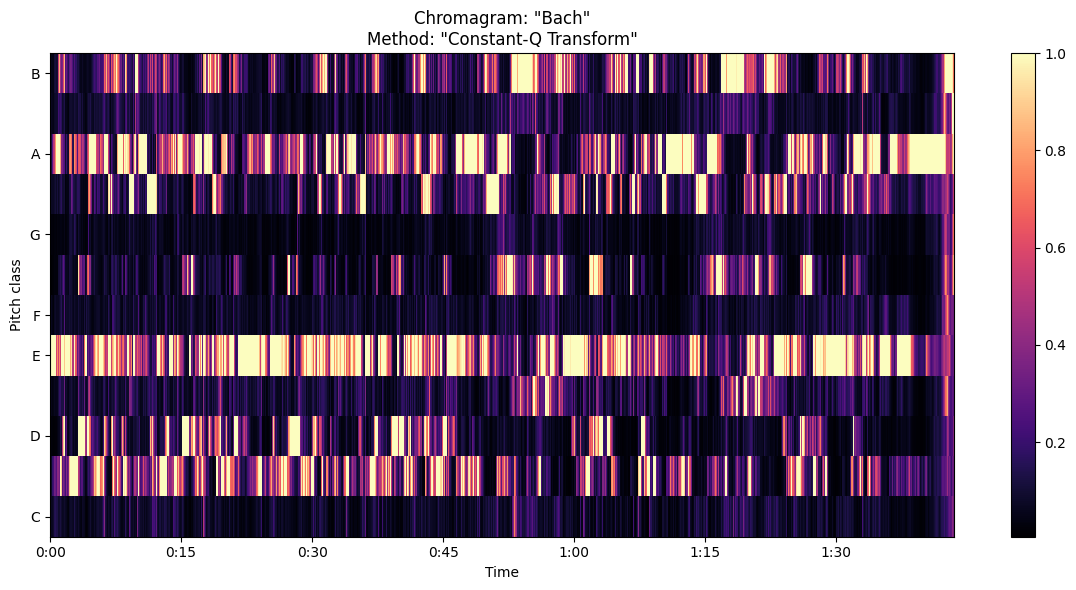

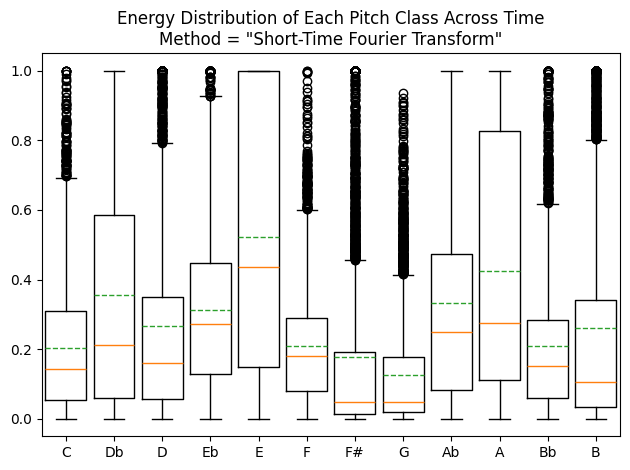

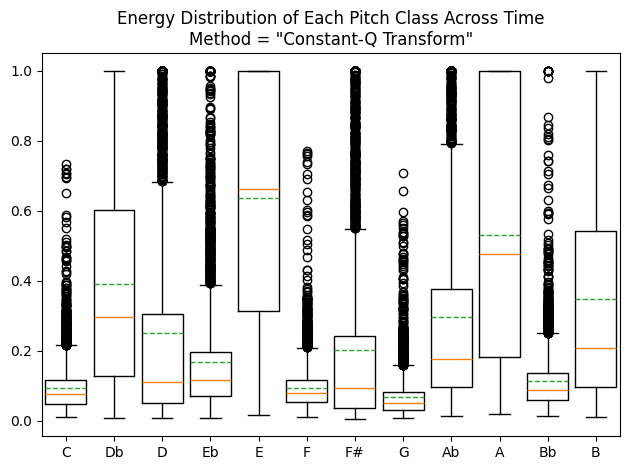

  track_title                          track_to_analyze_filename  \
0        Bach  /home/emily/Downloads/02 - Minuet from The Ann...   
1        Bach  /home/emily/Downloads/02 - Minuet from The Ann...   

                         method  hop_length  dissimilarity_index  \
0  Short-Time Fourier Transform        1024             0.155773   
1          Constant-Q Transform        1024             0.272845   

   chi2_goodness_of_fit_statistic  chi2_goodness_of_fit_p_value  \
0                     1444.877588                 2.496182e-303   
1                     4295.643536                  0.000000e+00   

   chi2_goodness_of_fit_cohens_w  kurtosis   entropy  
0                      10.972988 -0.206856  2.415076  
1                      18.920103 -0.490005  2.277656  


In [2]:
track_to_analyze = '/home/emily/Downloads/02 - Minuet from The Anna Magdalena Bach Notebook, Anh. 114.mp3'
track_name = 'Bach'
t_bach = KeyDetection(track_to_analyze, track_name)
t_bach.fit()
t_bach.summary_full()

In [3]:
t_bach.df

,track_title,track_to_analyze_filename,method,hop_length,key_as_chromatic_index,key_as_pitch_class,dissimilarity_index,chi2_goodness_of_fit_statistic,chi2_goodness_of_fit_p_value,chi2_goodness_of_fit_cohens_w,kurtosis,entropy
0,Bach,/home/emily/Downloads/02 - Minuet from The Ann...,Short-Time Fourier Transform,1024,4,E,0.155773,1444.877588,2.496182e-303,10.972988,-0.206856,2.415076
1,Bach,/home/emily/Downloads/02 - Minuet from The Ann...,Constant-Q Transform,1024,4,E,0.272845,4295.643536,0.000000e+00,18.920103,-0.490005,2.277656


## Stravinsky

In [ ]:
track_to_analyze = '/home/emily/Downloads/04 - The Rite of Spring (Scenes of Pagan Russia in Two Parts)_ Part One - Spring Rounds (1921 Version).mp3'
track_name = 'Stravinsky'
t_strv = KeyDetection(track_to_analyze, track_name)
t_strv.fit()
t_strv.summary_full()

In [ ]:
t_strv.df

## Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix)

In [ ]:
track_to_analyze = '/home/emily/Downloads/Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix).mp3'
track_name = 'Kwiky Bridge (Instant Satisfaction Mix)'
t_kb = KeyDetection(track_to_analyze, track_name)
t_kb.fit()
t_kb.summary_full()

In [ ]:
t_kb.df

## Lady Napalm - Voice in the Distance

In [ ]:
track_to_analyze = '/home/emily/Downloads/Lady Napalm - Voice in the Distance.mp3'
track_name = 'Voice in the Distance'
t_vd = KeyDetection(track_to_analyze, track_name)
t_vd.fit()
t_vd.summary_full()

In [ ]:
t_vd.df